<a href="https://colab.research.google.com/github/jasreman8/LLMs-for-Classification-and-Text-Generation/blob/main/Sentiment_%26_ABSA_with_LLMs_(Zero_shot_vs_Few_shot).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

Implement a workflow that utilizes LLMs to perform two text classification tasks:  
- Sentiment Analysis  
- Aspect-Based Sentiment Analysis  

# Setup

In [1]:
!pip install -q openai==1.66.3 datasets==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.4/567.4 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.


In [2]:
import json
import numpy as np

from openai import OpenAI
from datasets import load_dataset

from google.colab import userdata
from tqdm import tqdm

In [3]:
openai_api_key = userdata.get('my_api_key')

client = OpenAI(
    api_key=openai_api_key,
)

model_name = 'gpt-4o-mini'

# Text-To-Label Tasks

## Overview

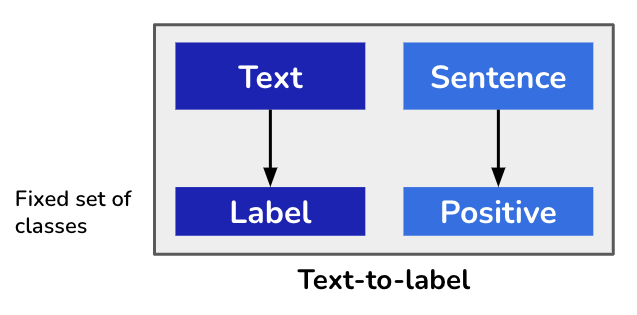

Text-to-label tasks are a core NLP task where the objective is to classify input text to a predefined set of classes. LLMs achieve high accuracy on these with a far lesser data requirement and no model training. In this notebook we will look at how LLM prompts could be designed and evaluated for text-to-label tasks using sentiment analysis as an example. The approach in this notebook can be extended to any other classification task.

We begin by presenting a workflow for prompt design and evaluation for classification tasks.

## Workflow

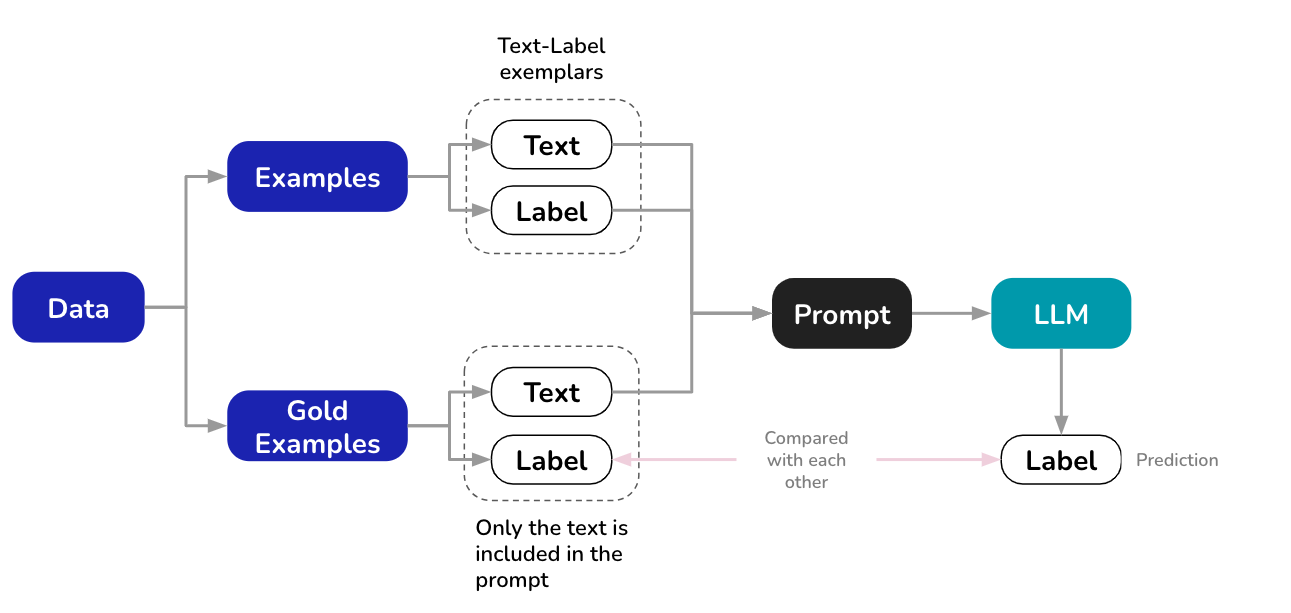

As indicated in the above figure, we do need data to prime the LLM for classification tasks. However, when using LLMs, the requirement on data is several order of magnitudes lesser since there is no training involved. Data used to achieve classification tasks comprises examples and gold examples. Examples are input-output exemplars (usually not more than 8) included in the prompt to prime it for expected label generation. Gold examples are inputs for evaluation where we have ground truth available and predictions from the LLM for the inputs is compared with the ground truths. We choose the best *prompt* as the one that scores high on predefined metrics (e.g., accuracy) on the set of gold examples. The complete iterative workflow is presented below.

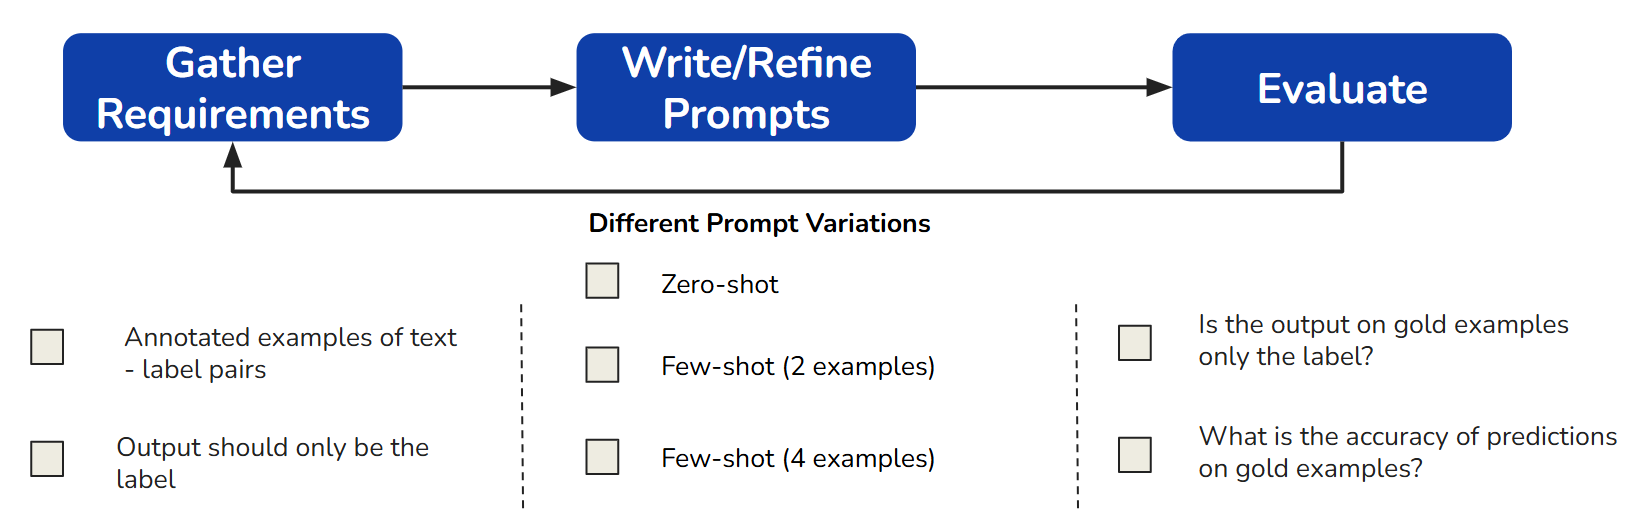

## Evaluation

Performance of prompts for classification tasks can be measured using accuracy.

**Accuracy:**

Accuracy measures the proportion of correctly classified instances out of the total number of instances. It is calculated as the number of true positives (correctly classified instances) divided by the total number of instances. Accuracy provides a straightforward measure of a prompt's overall performance.

Let us now implement this workflow for sentiment analysis on a sample of Amazon reviews.

# Business Use Case

Most organizations mandate product managers to constantly monitor product reviews on ecommerce sites such as Amazon to digest user feedback and gain insights into product adoption. Given the volume of reviews that a product team has to deal with, sifting through reviews and flagging those that warrant a response is a human-intensive task that is ripe for automation. In this context, assigning sentiment to product reviews (sentiment analysis) and identifying specific aspects of the product and the associated sentiment (aspect-based sentiment analysis) become critical.

# Sentiment Analysis

## Prompt Design

This section focuses on designing two zero-shot prompts and two few-shot prompts for sentiment analysis. To create the few-shot prompts, a set of input-output examples will first be assembled. The prompts will then be constructed using the Azure OpenAI API format.

To evaluate the prompts' performance, a set of *gold examples*—inputs with known labels—will be used. These examples, combined with the prompts, will be input into the LLM. The predictions generated by the LLM will then be compared to the known labels, allowing us to calculate the accuracy of each prompt.

An iterative approach will be employed, as illustrated in the figure above. Prompts will be refined and evaluated in successive iterations to improve their performance.

**Examples and Gold Examples**

A set of examples and gold examples for sentiment classification of Amazon product reviews is hosted in a HuggingFace dataset. Let us load this data and take a look at the samples in this data.

**Note that since this data is hosted on HuggingFace and you will need to create an API key and store it within Colab (just like the Azure API key) for dataset access.**

In [5]:
amazon_reviews = load_dataset("pgurazada1/amazon_polarity")

examples.csv: 0.00B [00:00, ?B/s]

gold-examples.csv: 0.00B [00:00, ?B/s]

Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

As is evident from the above output, the data set has 32 samples as examples and 32 samples as gold examples.

In [6]:
amazon_reviews_examples_df = amazon_reviews['examples'].to_pandas()
amazon_reviews_gold_examples_df = amazon_reviews['gold_examples'].to_pandas()

In [7]:
amazon_reviews_examples_df.shape, amazon_reviews_gold_examples_df.shape

((32, 2), (32, 2))

In [8]:
amazon_reviews['examples'].to_pandas()['content'].iloc[2]

'This book was written by a chair within the American Dietetic Association. It is the most comprehensive veg nutrition book I have ever read, and offers astounding evidence that eating a vegan diet dramatically reduces most of the diseases that plague modern society, including certain types of cancer, heart disease, and diabetes. She bases all of her statements on sound research and an historical study comparing disease rates in vegan and meat-eating populations. I pay attention to nutrition, but I still learned a lot by reading this book. Her suggestions probably saved me a lot of grief in the future.An extremely valuable book. I can\'t recommend it highly enough.(Another book that compares diets over decades is "The China Study.")'

As the above outputs indicate, there are 32 examples and 32 gold examples. We will sample from the examples to create the few shot prompt and evaluate the prompt on all 32 gold examples.

In [9]:
amazon_reviews_examples_df.sample(4)

,content,label
19,It seems that the same people who don't like S...,1
18,These traps are virtually impossible to set. T...,0
22,Judging by the artists contributing on this al...,0
2,This book was written by a chair within the Am...,1


As the above data indicates, positive reviews are annotated with the label 1 and negative reviews are annotated with the label 0.

**Assembling and evaluating prompts**

*Zero-shot*

Let us assemble a naive zero-shot prompt and evaluate it.

In [10]:
zero_shot_system_message_v1 = """
Classify product reviews in the input as positive or negative in sentiment.
"""
zero_shot_prompt_v1 = [{'role': 'developer',
                        'content': zero_shot_system_message_v1}]
zero_shot_prompt_v1

[{'role': 'developer',
  'content': '\nClassify product reviews in the input as positive or negative in sentiment.\n'}]

To evaluate this prompt (and all the further iterations), we compose a function that computes accuracy of a prompt over a set of gold examples.

In [11]:
def compute_accuracy(prompt, gold_examples_df):
    """Computes the accuracy of an LLM's predictions on a set of gold examples.

    This function evaluates the performance of a prompt by comparing the LLM's predictions
    against the true labels of a set of gold examples. It calculates accuracy as the
    proportion of correctly classified instances.

    Args:
        prompt (list): The prompt to be used for the LLM, formatted as a list of
                       dictionaries with 'role' and 'content' keys.
        gold_examples_df (pd.DataFrame): A pandas DataFrame containing the gold examples,
                                          where each row represents an example with
                                          the review text in the first column and
                                          the true label in the second column.

    Returns:
        float: The accuracy of the LLM's predictions, which is a value between 0 and 1
               representing the proportion of correctly classified instances.
    """
    predictions, ground_truths = [], []  # Initialize lists to store predictions and true labels

    # Iterate through each gold example using tqdm for progress visualization
    for index, row in tqdm(gold_examples_df.iterrows()):
        gold_review = row.iloc[0]  # Extract the review text from the DataFrame row
        gold_label = row.iloc[1]  # Extract the true label from the DataFrame row

        user_input = [{'role':'user', 'content': gold_review}]  # Format user input for the LLM

        try:
            # Send the prompt and review to the LLM and get the response
            # https://colab.research.google.com/drive/1HCunuzUmx21Oy7mnf1mgyGQ32JDxNhd0#scrollTo=Aspect_Based_Sentiment_Analysis_ABSA_
            response = client.chat.completions.create(
                model=model_name,  # Use the specified LLM model
                messages=prompt + user_input,  # Combine the prompt and user input
                temperature=0  # Set temperature to 0 for deterministic predictions (accurate predictions/no creativity)
            )

            # Convert the LLM's prediction to an integer and append to predictions list
            predictions.append(int(response.choices[0].message.content))
            ground_truths.append(gold_label)  # Append the true label to ground_truths list
        except Exception as e:
            print(e)  # Log any errors encountered during LLM interaction
            continue  # Move on to the next example if an error occurs

    predictions = np.array(predictions)  # Convert predictions list to a NumPy array
    ground_truths = np.array(ground_truths)  # Convert ground_truths list to a NumPy array

    # Calculate and return the accuracy as the mean of correct predictions
    return (predictions == ground_truths).mean()

In [12]:
compute_accuracy(zero_shot_prompt_v1, amazon_reviews_gold_examples_df)

1it [00:01,  1.22s/it]

invalid literal for int() with base 10: 'Positive'


2it [00:02,  1.38s/it]

invalid literal for int() with base 10: 'Negative'


3it [00:03,  1.33s/it]

invalid literal for int() with base 10: 'Negative'


4it [00:05,  1.42s/it]

invalid literal for int() with base 10: 'Negative'


5it [00:06,  1.23s/it]

invalid literal for int() with base 10: 'Negative'


6it [00:06,  1.06it/s]

invalid literal for int() with base 10: 'Negative'


7it [00:07,  1.16it/s]

invalid literal for int() with base 10: 'Negative'


8it [00:08,  1.25it/s]

invalid literal for int() with base 10: 'Positive'


9it [00:08,  1.53it/s]

invalid literal for int() with base 10: 'Positive'


10it [00:08,  1.73it/s]

invalid literal for int() with base 10: 'Positive'


11it [00:09,  1.86it/s]

invalid literal for int() with base 10: 'Negative'


12it [00:10,  1.75it/s]

invalid literal for int() with base 10: 'Positive'


13it [00:11,  1.25it/s]

invalid literal for int() with base 10: 'Positive'


14it [00:11,  1.51it/s]

invalid literal for int() with base 10: 'Negative'


15it [00:12,  1.74it/s]

invalid literal for int() with base 10: 'Negative'


16it [00:13,  1.27it/s]

invalid literal for int() with base 10: 'Positive'


17it [00:13,  1.49it/s]

invalid literal for int() with base 10: 'Negative'


18it [00:14,  1.74it/s]

invalid literal for int() with base 10: 'Positive'


19it [00:14,  1.97it/s]

invalid literal for int() with base 10: 'Negative'


20it [00:14,  2.01it/s]

invalid literal for int() with base 10: 'The sentiment of the review is negative.'


21it [00:16,  1.13it/s]

invalid literal for int() with base 10: 'Negative'


22it [00:17,  1.32it/s]

invalid literal for int() with base 10: 'Negative'


23it [00:18,  1.21it/s]

invalid literal for int() with base 10: 'Positive'


24it [00:19,  1.14it/s]

invalid literal for int() with base 10: 'The sentiment of the review is mixed, but leans towards positive. The reviewer initially finds the book enjoyable, despite calling it "trashy," and acknowledges that the theories have gained scientif


25it [00:19,  1.39it/s]

invalid literal for int() with base 10: 'Positive'


26it [00:20,  1.18it/s]

invalid literal for int() with base 10: 'The sentiment of the review is mixed, but leans towards negative due to the concerns about the juicer getting hot, dull blades, and the need for replacement.'


27it [00:21,  1.10it/s]

invalid literal for int() with base 10: 'Negative'


28it [00:22,  1.14it/s]

invalid literal for int() with base 10: 'Negative'


29it [00:23,  1.15it/s]

invalid literal for int() with base 10: 'Positive'


30it [00:23,  1.34it/s]

invalid literal for int() with base 10: 'Negative'


31it [00:24,  1.60it/s]

invalid literal for int() with base 10: 'Positive'


32it [00:24,  1.30it/s]

invalid literal for int() with base 10: 'Positive'



/tmp/ipython-input-288826819.py:49: RuntimeWarning: Mean of empty slice.
  return (predictions == ground_truths).mean()
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


np.float64(nan)

The above zero-shot prompt demonstrates poor accuracy since the output is a mix of full sentences, and the words 'Positive' or 'Negative'. What we need is a label: 1 for positive sentiment and 0 or negative sentiment. Let us now refine the zero-shot prompt so that it corrects for this mistake and follows prompt engineering best practises (e.g., adopting a role and clear instructions).

In [13]:
zero_shot_system_message_v2 = """
You are a product specialist tasked to classify product reviews in the input as positive or negative in sentiment.
Your answer should only contain the label: 1 (positive) or 0 (negative).
"""

zero_shot_prompt_v2 = [{'role': 'developer', 'content': zero_shot_system_message_v2}]
zero_shot_prompt_v2

[{'role': 'developer',
  'content': '\nYou are a product specialist tasked to classify product reviews in the input as positive or negative in sentiment.\nYour answer should only contain the label: 1 (positive) or 0 (negative).\n'}]

In [14]:
compute_accuracy(zero_shot_prompt_v2, amazon_reviews_gold_examples_df)

32it [00:13,  2.29it/s]


np.float64(0.96875)

This version of the zero-shot prompt now demonstrates a good accuracy while avoiding the errors on output from the previous version.

Now let us use this zero-shot system message and start adding examples to see if accuracy improves.

*Few-shot (2 examples)*

In [15]:
few_shot_system_message = """
You are a product specialist tasked to classify product reviews in the input as positive or negative in sentiment.
Do not explain your answer. Your answer should only contain the label: 1 (positive) or 0 (negative).
"""
few_shot_prompt_2examples = [{'role': 'developer', 'content': few_shot_system_message}]

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [16]:
for index, row in amazon_reviews_examples_df.iterrows():
    print('Example Review:')
    print(row.iloc[0])
    print('Example Label:')
    print(row.iloc[1])
    break

Example Review:
i bought three of these and had problems with all three! as another reviewer noted, any time you touch the wire, this thing goes off and i have to manually reset which causes an odd buzzing that i don't like the sound of. i have this under my computer desk and occasionally hit the wire with my feet. a surge protector should be more robust than this and since i have had the same problem with three units ( i bought them all at once or would never repurchase)i don't believe it is a rare defect but built into the design.
Example Label:
0


Notice that the label is an integer. However, LLMs accept only strings. So we need to convert the integer label to a string label as we assemble the few-shot prompt. Let us assemble a few-shot prompt with 2 examples.

In [17]:
for index, row in amazon_reviews_examples_df.sample(2).iterrows():
    """
    Iterates through 2 randomly sampled rows from the 'amazon_reviews_examples_df' DataFrame.

    Args:
        index: The index of the row.
        row: A pandas Series representing the row data.

    Purpose:
        This loop selects two random examples from the DataFrame and formats them for use in a few-shot prompt for an LLM.
        It appends each example review and its corresponding label to the 'few_shot_prompt_2examples' list in the required format for the LLM.
    """
    example_review = row.iloc[0]  # Extracts the review text from the first column of the row
    example_label = row.iloc[1]  # Extracts the sentiment label from the second column of the row

    few_shot_prompt_2examples.append(
        {
            'role': 'user',
            'content': example_review
        }
    )  # Appends the example review as a 'user' message to the prompt list

    few_shot_prompt_2examples.append(
        {
            'role': 'assistant',
            'content': str(example_label)  # Converts the label to a string as LLMs only accept string inputs
        }
    )  # Appends the example label as an 'assistant' message to the prompt list

In [18]:
few_shot_prompt_2examples

[{'role': 'developer',
  'content': '\nYou are a product specialist tasked to classify product reviews in the input as positive or negative in sentiment.\nDo not explain your answer. Your answer should only contain the label: 1 (positive) or 0 (negative).\n'},
 {'role': 'user',
  'content': "There's no denying that Monster House for the PlayStation 2 and the GameCube does a good job of duplicating the atmosphere of the movie it's based on. Every key scene from the movie is represented in some fashion, and the game's spooky musical score is on par with Hollywood's best. Unfortunately, while the game is a joy to sit back and take in, it isn't much fun to interact with. The movie has been transformed into a third-person action game that mainly involves fighting the same cookie-cutter enemies over and over again in the same cramped environments. To make matters worse, various other dubious design decisions bring about fits of frustration along the way that really shouldn't be in a game tha

In [19]:
compute_accuracy(few_shot_prompt_2examples, amazon_reviews_gold_examples_df)

32it [00:10,  3.14it/s]


np.float64(0.96875)

There is no substantive improvement in accuracy with additional examples. Let us now add few more examples and create another few-shot variant keeping the system message the same.

*Few-shot (4 examples)*

In [20]:
few_shot_system_message = """
You are a product specialist tasked to classify product reviews in the input as positive or negative in sentiment.
Do not explain your answer. Your answer should only contain the label: 1 (positive) or 0 (negative).
"""

In [21]:
few_shot_prompt_4examples = [{'role':'developer', 'content': few_shot_system_message}]

In [22]:
for index, row in amazon_reviews_examples_df.sample(4).iterrows():
    example_review = row.iloc[0]
    example_label = row.iloc[1]

    few_shot_prompt_4examples.append(
        {
            'role': 'user',
            'content': example_review
        }
    )

    few_shot_prompt_4examples.append(
        {
            'role': 'assistant',
            'content': str(example_label) # LLMs accept only string inputs
        }
    )

In [23]:
few_shot_prompt_4examples

[{'role': 'developer',
  'content': '\nYou are a product specialist tasked to classify product reviews in the input as positive or negative in sentiment.\nDo not explain your answer. Your answer should only contain the label: 1 (positive) or 0 (negative).\n'},
 {'role': 'user',
  'content': 'I love music and I love Christmas. This CD has something for everyone to love. Anyone who has sang in choir will really appreciate the talent here, and those who have not will be pleasantly surprised at this vocal delight. My Christmas music collection has everything - classic, country, pop rock, religous. This CD is at the top of my list and I will be listening to it all year long! If you want something different, that will please listeners of all ages, this is the Christmas CD for you!'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'user',
  'content': 'Divine visions presented to a run away in a NW forest, or were they something else? A guilt-ridden, angry ex-logger, and a priest with a sh

In [24]:
compute_accuracy(few_shot_prompt_4examples, amazon_reviews_gold_examples_df)

32it [00:10,  3.08it/s]


np.float64(0.9375)

As shown by the accuracy estimates above, there is no significant difference in performance between the second zero-shot prompt version and the few-shot prompts.

This section implements the iterative approach to developing the optimal prompt. Each variation of the prompt is evaluated to measure its performance using a set of gold examples. The prompt that achieves the best performance on these gold examples is selected as the final version for use with new user inputs like so:

In [25]:
final_system_message = """
You are a product specialist tasked to classify product reviews in the input as positive or negative in sentiment.
Your answer should only contain the label: 1 (positive) or 0 (negative).
"""

final_prompt_zero_shot = [{'role': 'developer', 'content': final_system_message}]

In [26]:
new_reviews = [
"""
I recently purchased this noise-canceling headphone set, and it has completely transformed how I experience music and focus on work. Developed by one of the leading brands in audio technology, these headphones deliver unparalleled sound quality and truly effective noise cancellation. Whether it's classical music, podcasts, or calls, the audio clarity is phenomenal, and the comfort of the ear cushions allows for extended use without fatigue. The battery life exceeds expectations, lasting several days of moderate use before needing a recharge. Having tried many headphones over the years, I can confidently say this is the best investment I've made in audio equipment. It’s a game-changer for anyone looking to enhance their listening experience or work in peace. Highly recommended.
""",

"""
This vacuum cleaner is an absolute powerhouse, and it has made keeping my home clean so much easier. Designed by a trusted brand in home appliances, it combines high suction power with intelligent features like auto-adjusting brush heads for different floor types. It easily tackles everything from pet hair on carpets to crumbs on hardwood floors. The cordless design and long-lasting battery give it unmatched convenience, while the lightweight frame makes it effortless to maneuver. The added HEPA filter is a bonus, capturing dust and allergens to improve air quality. I never thought I could be this impressed by a vacuum, but it’s honestly one of the best purchases I’ve made for my household.
""",

"""
This hiking backpack exceeded all my expectations and has quickly become an essential part of my outdoor adventures. It was designed with input from seasoned hikers, and it shows in every detail. The ergonomic design distributes weight evenly, making long hikes much more comfortable. The multiple compartments and hydration system are perfectly placed, and the durable, weather-resistant material holds up in rain and rugged terrain. I’ve used it on several challenging hikes, and it keeps everything organized and accessible, from snacks to first-aid kits. For anyone serious about hiking or outdoor activities, this backpack is a must-have. It’s well worth the investment.
"""
]

In [27]:
for review in new_reviews:
    user_input = [{'role': 'user', 'content': review}]
    response = client.chat.completions.create(
        model=model_name,
        messages=final_prompt_zero_shot + user_input,
        temperature=0
    )

    print(response.choices[0].message.content)

1
1
1


Also, notice that we do not parametrize maximum output tokens for any of the prompt evaluations. Examples in the few-shot prompts provide valuable guidance on both the format of the output (i.e., 1 or 0) and the number of tokens expected in the output.

>More examples does not imply better accuracy. Increasing the number of examples in the few-shot prompt beyond 16 is not known to yield better performance.

# Aspect-Based Sentiment Analysis (ABSA)

So far, we have been concerned with the overall sentiment of the input. However, when there are several aspects ("themes") that are included in the input text, it is not necessary that all the aspects of the input share the same sentiment. For example, when reviewing a mobile phone, a customer might express sentiment about the different features of the phone (e.g., camera, storage, screen, processor) and these features might not share the same sentiment. It is likely that while the customer liked the camera, they expressed concern about the storage on the phone.

In aspect-based sentiment analysis (ABSA), the aim is to identify the aspects of entities and the sentiment expressed for each aspect. The ultimate goal is to be able to generate a measure of polarity that explicitly accounts for the different aspects of the input. In this way, ABSA presents a nuanced version of the overall polarity of the sentiment expresses in the input. For effective ABSA, we should be able to generate appropriate themes and then assign sentiment to the portions of the input that correspond to this theme.

## Prompt Design

We will design two few-shot prompts for ABSA (Aspect-Based Sentiment Analysis). To begin, we will compile a set of input-output examples to form the basis of the few-shot prompt. Once the examples are assembled, we will format the prompt according to the Azure OpenAI API specifications.

To evaluate the performance of the *prompt*, we will use a separate set of *gold examples*—a collection of examples not included in the prompt itself. These gold examples serve as an independent benchmark to assess the model's accuracy.

As demonstrated in the previous section, we will analyze how variations in the prompt affect accuracy using the same iterative workflow. The prompt configuration that achieves the highest accuracy will be selected.

**Examples and Gold Examples**

A set of examples and gold examples for aspect-based sentiment classification of restaurant reviews is hosted in a HuggingFace dataset. Let us load this data and take a look at the samples in this data.

For our prompts, we will use 4 few-shot examples and evaluate the prompts on 32 gold examples.

In [28]:
aspect_based_restaurant_reviews_corpus = load_dataset("jakartaresearch/semeval-absa", "restaurant")

restaurant_reviews_examples_df = aspect_based_restaurant_reviews_corpus['train'].to_pandas()
restaurant_reviews_gold_examples_df = aspect_based_restaurant_reviews_corpus['validation'].to_pandas()

examples_json = restaurant_reviews_examples_df.sample(4, random_state=42).to_json(orient='records')
gold_examples_json = restaurant_reviews_gold_examples_df.sample(32, random_state=42).to_json(orient='records')

README.md: 0.00B [00:00, ?B/s]

semeval-absa.py: 0.00B [00:00, ?B/s]

0000.parquet:   0%|          | 0.00/231k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3044 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/800 [00:00<?, ? examples/s]

In [29]:
json.loads(examples_json)

[{'id': '395',
  'text': 'The sake menu should not be overlooked!',
  'aspects': {'term': ['sake menu'],
   'polarity': ['positive'],
   'from': [4],
   'to': [13]},
  'category': {'category': ['food'], 'polarity': ['positive']}},
 {'id': '527',
  'text': 'Great spot, whether looking for a couple of drinks or quiet dinner.',
  'aspects': {'term': ['drinks', 'dinner', 'spot'],
   'polarity': ['positive', 'positive', 'positive'],
   'from': [44, 60, 6],
   'to': [50, 66, 10]},
  'category': {'category': ['ambience'], 'polarity': ['positive']}},
 {'id': '570',
  'text': 'I was there on sat.',
  'aspects': {'term': [''], 'polarity': [''], 'from': [0], 'to': [0]},
  'category': {'category': ['anecdotes/miscellaneous'],
   'polarity': ['neutral']}},
 {'id': '1203',
  'text': 'I came to this restaurant expecting to be surprised but left bored and overcharged.',
  'aspects': {'term': [''], 'polarity': [''], 'from': [0], 'to': [0]},
  'category': {'category': ['anecdotes/miscellaneous', 'price'

The code above generates a list of examples, where each entry in the list is a dictionary. Each dictionary contains two keys that we focus on: `text`, which holds the review text, and `category`, which contains another dictionary detailing the aspects (categories) and their corresponding polarities.

**Assembling & evaluating prompts**

Let us now assemble a first version of the prompt and evaluate its performance on the gold examples.

In [30]:
few_shot_system_message_v1 = """
Perform aspect based sentiment analysis on restaurant reviews presented in the input.
In each review there might be one or more of the following aspects: food, service, ambience, anecdotes/miscellaneous.
Arrange your response as a JSON object with the following headers:
- category:[list of aspects]
- polarity:[list of corresponding polarities for each aspect]
"""

In [31]:
few_shot_prompt_v1 = [{'role':'developer', 'content': few_shot_system_message_v1}]

To complete the few-shot prompt, we need to iterate over the examples to append these examples as `user` and `assistant` messages to the few-shot prompt.

In [32]:
for example in json.loads(examples_json):
    print(example['text'])
    print('--')
    print(example['category'])
    break

The sake menu should not be overlooked!
--
{'category': ['food'], 'polarity': ['positive']}


Notice that the label is a dictionary. However, LLMs accept only strings. So we need to convert this dictionary to a string label as we assemble the few-shot prompt.

Let us now  assemble the first few-shot prompt with 4 examples.

In [33]:
for example in json.loads(examples_json):  # Iterate through each example in the loaded JSON data
    example_review = example['text']  # Extract the review text from the example
    example_label = example['category']  # Extract the category/label from the example

    few_shot_prompt_v1.append(  # Append the example to the few-shot prompt
        {
            'role': 'user',
            'content': example_review  # Include the review text as content
        }
    )

    few_shot_prompt_v1.append(  # Append the expected output to the few-shot prompt
        {
            'role': 'assistant',
            'content': str(example_label)  # Include the category/label as content (converted to string)
        }
    )

In [34]:
few_shot_prompt_v1

[{'role': 'developer',
  'content': '\nPerform aspect based sentiment analysis on restaurant reviews presented in the input.\nIn each review there might be one or more of the following aspects: food, service, ambience, anecdotes/miscellaneous.\nArrange your response as a JSON object with the following headers:\n- category:[list of aspects]\n- polarity:[list of corresponding polarities for each aspect]\n'},
 {'role': 'user', 'content': 'The sake menu should not be overlooked!'},
 {'role': 'assistant',
  'content': "{'category': ['food'], 'polarity': ['positive']}"},
 {'role': 'user',
  'content': 'Great spot, whether looking for a couple of drinks or quiet dinner.'},
 {'role': 'assistant',
  'content': "{'category': ['ambience'], 'polarity': ['positive']}"},
 {'role': 'user', 'content': 'I was there on sat.'},
 {'role': 'assistant',
  'content': "{'category': ['anecdotes/miscellaneous'], 'polarity': ['neutral']}"},
 {'role': 'user',
  'content': 'I came to this restaurant expecting to b

We now need to evaluate this prompt on the gold examples using accuracy of the output as a metric.

As in the case of sentiment analysis discussed in the previous task, we assign positive or negative sentiment to a review, with the additional objective of identifying entities (if any) present in the review.

To evaluate model performance, we judge the accuracy of the aspects + sentiment assignment per aspect. Note that this is a much more stringent measure compared to the sentiment classification task we have seen so far. For example, if aspects identified by the LLM do not match the ground truth for a specific input, we count this prediction to be incorrect. A correct prediction is one where all the aspects are correctly idenfied and further the sentiment assignment for each aspect is also correctly identified (see figure below).

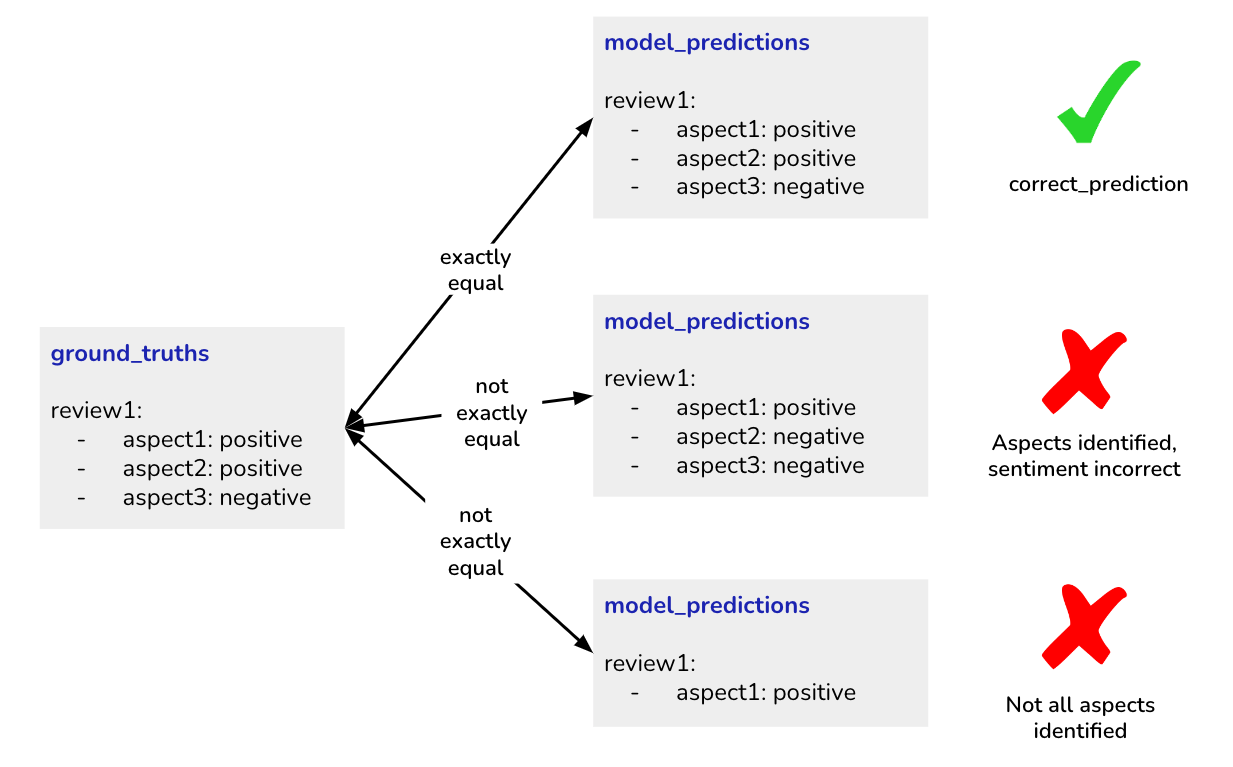

For each gold example, we will collect LLM predictions generated using version 1 of the few-shot prompt, along with the corresponding ground truths, to enable straightforward comparisons.

In [35]:
def predict(gold_examples_json, prompt):
    """Predicts labels for a set of examples using a large language model (LLM).

    This function takes a JSON string containing gold examples and a prompt as input.
    It iterates through each example, sends it to the LLM for prediction,
    and compares the prediction with the ground truth label.
    The results are stored in two lists: `model_predictions` and `ground_truths`.

    Args:
        gold_examples_json (str): A JSON string containing gold examples,
                                     where each example has 'text' and 'category' fields.
        prompt: The prompt to be used for the LLM.

    Returns:
        tuple: A tuple containing two lists:
            - model_predictions (list): A list of predicted labels for each example.
            - ground_truths (list): A list of ground truth labels for each example.
    """
    model_predictions, ground_truths = [], []  # Initialize lists to store predictions and ground truths

    # Iterate through each example in the parsed gold examples JSON data
    for example in json.loads(gold_examples_json):
        gold_review = example['text']  # Extract the text of the review
        gold_label = example['category']  # Extract the true category label

        # Format the review as a user message for the LLM
        user_input = [{'role':'user', 'content': gold_review}]

        try:
            # Send the prompt and user input to the LLM to get a prediction
            response = client.chat.completions.create(
                model=model_name,  # Specify the LLM model name
                messages=prompt + user_input,  # Combine the few-shot prompt and user input
                temperature=0  # Set temperature to 0 for deterministic output
            )

            # Extract and format the prediction
            prediction = response.choices[0].message.content.replace("'", "\"")  # Replace single quotes with double quotes for JSON compatibility

            # Store the prediction and ground truth
            model_predictions.append(json.loads(prediction.strip().lower()))  # Parse prediction, strip whitespace, convert to lowercase, and append to list
            ground_truths.append(example['category'])  # Append the true category label to the ground truths list

        except Exception as e:
            print(e)  # Print any errors encountered during the process
            continue  # Skip to the next example if an error occurs

    return model_predictions, ground_truths  # Return the predictions and ground truths

In [36]:
model_predictions, ground_truths = predict(gold_examples_json, few_shot_prompt_v1)

We can now directly compare the model predictions with ground truths to estimate the accuracy of the prompt using a function like so:

In [37]:
def compute_accuracy(model_predictions, ground_truths, num_gold_examples=32):

    """
    Return the accuracy score comparing the model predictions and ground truth
    for ABSA. We look for exact matches between the model predictions on all the
    aspects and sentiments for these aspects in the ground truth.

    Args:
        gold_examples (str): JSON string with list of gold examples
        model_predictions (List): Nested list of ABSA predictions
        ground_truths (List): Nested list of ABSA annotations

    Output:
        accuracy (float): Exact matches of model predictions and ground truths
    """
    # Initialize variables to keep track of correct and total predictions
    correct_predictions = 0

    # Iterate through each prediction and ground truth pair
    for pred, truth in zip(model_predictions, ground_truths):
        if pred == truth:
            correct_predictions += 1

    # Calculate accuracy as the ratio of correct predictions to total predictions
    accuracy = correct_predictions / num_gold_examples

    return accuracy

In [38]:
compute_accuracy(model_predictions, ground_truths)

0.65625

Let us now write a more nuanced system message and evaluate this variation on the same set of gold examples.

In [39]:
few_shot_system_message_v2 = """
You are an expert restaurant manager tasked to perform aspect based sentiment analysis on restaurant reviews.
Identify the sentiment (polarity) for each aspect in the review and classify them into four possible categories: `food`, `service`, `ambience`, and `anecdotes/miscellaneous`. Return the response in structured JSON format as specified below.

Use the following steps to guide your analysis:

1. **Review Analysis**: For each review provided, identify one or more of the four aspects (food, service, ambience, anecdotes/miscellaneous) mentioned.
2. **Sentiment Detection**: Determine the polarity of each identified aspect. Use the following scale for polarity:
   - Positive
   - Negative
   - Neutral
3. Output the results in JSON format, ensuring alignment between the aspects and their corresponding polarities.
4. Note that there might be a mention of some aspects in the review but specific comments are not made.
For such aspects where no specific polarity can be identified, do not mention this aspect in the output.

The output must be a JSON object structured as follows. Do NOT explain your answer:
- `"category"`: A list of aspects found in the review.
- `"polarity"`: A list of corresponding polarities for each aspect in the same order as `"category"`.
"""

In [40]:
few_shot_prompt_v2 = [{'role':'developer', 'content': few_shot_system_message_v2}]

for example in json.loads(examples_json):  # Iterate through each example in the loaded JSON data
    example_review = example['text']  # Extract the review text from the example
    example_label = example['category']  # Extract the category/label from the example

    few_shot_prompt_v2.append(  # Append the example to the few-shot prompt
        {
            'role': 'user',
            'content': example_review  # Include the review text as content
        }
    )

    few_shot_prompt_v2.append(  # Append the expected output to the few-shot prompt
        {
            'role': 'assistant',
            'content': str(example_label)  # Include the category/label as content (converted to string)
        }
    )

In [41]:
few_shot_prompt_v2

[{'role': 'developer',
  'content': '\nYou are an expert restaurant manager tasked to perform aspect based sentiment analysis on restaurant reviews.\nIdentify the sentiment (polarity) for each aspect in the review and classify them into four possible categories: `food`, `service`, `ambience`, and `anecdotes/miscellaneous`. Return the response in structured JSON format as specified below.\n\nUse the following steps to guide your analysis:\n\n1. **Review Analysis**: For each review provided, identify one or more of the four aspects (food, service, ambience, anecdotes/miscellaneous) mentioned.\n2. **Sentiment Detection**: Determine the polarity of each identified aspect. Use the following scale for polarity:\n   - Positive\n   - Negative\n   - Neutral\n3. Output the results in JSON format, ensuring alignment between the aspects and their corresponding polarities.\n4. Note that there might be a mention of some aspects in the review but specific comments are not made.\nFor such aspects wher

We can now collect predictions from the LLM as we did with the previous prompt variation (note that the only change is from prompt version v1 to v2).

In [42]:
model_predictions, ground_truths = predict(gold_examples_json, few_shot_prompt_v2)

We now compute accuracy using the same function defined previously.

In [43]:
compute_accuracy(model_predictions, ground_truths)

0.8125

 - Example 3

In [44]:
few_shot_system_message_v3 = """
You are an expert restaurant manager tasked to perform aspect based sentiment analysis on restaurant reviews.
Identify the sentiment (polarity) for each aspect in the review and classify them into four possible categories: `food`, `service`, `ambience`, and `anecdotes/miscellaneous`. Return the response in structured JSON format as specified below.

Use the following steps to guide your analysis:

1. **Review Analysis**: For each review provided, identify one or more of the four aspects (food, service, ambience, anecdotes/miscellaneous) mentioned.
2. **Sentiment Detection**: Determine the polarity of each identified aspect. Use the following scale for polarity:
   - Positive
   - Negative
3. Output the results in JSON format, ensuring alignment between the aspects and their corresponding polarities.
4. Note that there might be a mention of some aspects in the review but specific comments are not made.
For such aspects where no specific polarity can be identified, do not mention this aspect in the output.

The output must be a JSON object structured as follows. Do NOT explain your answer:
- `"category"`: A list of aspects found in the review.
- `"polarity"`: A list of corresponding polarities for each aspect in the same order as `"category"`.
"""

few_shot_prompt_v3 = [{'role':'developer', 'content': few_shot_system_message_v3}]

for example in json.loads(examples_json):  # Iterate through each example in the loaded JSON data
    example_review = example['text']  # Extract the review text from the example
    example_label = example['category']  # Extract the category/label from the example

    few_shot_prompt_v3.append(  # Append the example to the few-shot prompt
        {
            'role': 'user',
            'content': example_review  # Include the review text as content
        }
    )

    few_shot_prompt_v3.append(  # Append the expected output to the few-shot prompt
        {
            'role': 'assistant',
            'content': str(example_label)  # Include the category/label as content (converted to string)
        }
    )

model_predictions, ground_truths = predict(gold_examples_json, few_shot_prompt_v3)

compute_accuracy(model_predictions, ground_truths)

0.71875

We can now use this improved prompt on new reviews like so:

In [45]:
final_system_message = """
You are an expert restaurant manager tasked to perform aspect based sentiment analysis on restaurant reviews.
Identify the sentiment (polarity) for each aspect in the review and classify them into four possible categories: `food`, `service`, `ambience`, and `anecdotes/miscellaneous`. Return the response in structured JSON format as specified below.

Use the following steps to guide your analysis:

1. **Review Analysis**: For each review provided, identify one or more of the four aspects (food, service, ambience, anecdotes/miscellaneous) mentioned.
2. **Sentiment Detection**: Determine the polarity of each identified aspect. Use the following scale for polarity:
   - Positive
   - Negative
   - Neutral
3. Output the results in JSON format, ensuring alignment between the aspects and their corresponding polarities.
4. Note that there might be a mention of some aspects in the review but specific comments are not made.
For such aspects where no specific polarity can be identified, do not mention this aspect in the output.

The output must be a JSON object structured as follows. Do NOT explain your answer:
- `"category"`: A list of aspects found in the review.
- `"polarity"`: A list of corresponding polarities for each aspect in the same order as `"category"`.
"""

In [46]:
final_prompt_few_shot = [{'role':'developer', 'content': final_system_message}]

for example in json.loads(examples_json):  # Iterate through each example in the loaded JSON data
    example_review = example['text']  # Extract the review text from the example
    example_label = example['category']  # Extract the category/label from the example

    final_prompt_few_shot.append(  # Append the example to the few-shot prompt
        {
            'role': 'user',
            'content': example_review  # Include the review text as content
        }
    )

    final_prompt_few_shot.append(  # Append the expected output to the few-shot prompt
        {
            'role': 'assistant',
            'content': str(example_label)  # Include the category/label as content (converted to string)
        }
    )

In [47]:
new_reviews = [
"Perfect ambiance for a casual lunch or an intimate evening meal.",
"Ideal for a quick coffee break or a relaxed weekend brunch with friends.",
"A cozy place, equally suited for catching up over drinks or enjoying a hearty dinner."
]

In [48]:
for review in new_reviews:
    user_input = [{'role': 'user', 'content': review}]
    response = client.chat.completions.create(
        model=model_name,
        messages=final_prompt_few_shot + user_input,
        temperature=0
    )

    print(response.choices[0].message.content)

{'category': ['ambience'], 'polarity': ['positive']}
{'category': ['ambience'], 'polarity': ['positive']}
{'category': ['ambience', 'food'], 'polarity': ['positive', 'positive']}
